In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# manual seed
torch.manual_seed(42)

In [3]:
# load data
df = pd.read_csv('/content/fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [4]:
df.shape

(6000, 785)

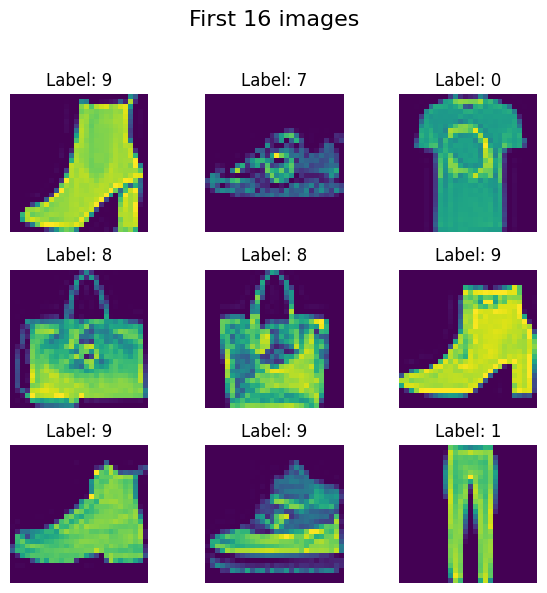

In [5]:
# show images
fig, axes = plt.subplots(3, 3, figsize = (6, 6))
fig.suptitle('First 16 images', fontsize = 16)

for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label: {df.iloc[i, 0]}')

plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.show()

In [6]:
# convert X and y
X = df.drop(columns = ['label'], axis = 1)
y = df['label']

In [7]:
df['label'].value_counts()

,count
label,
6,656
7,620
5,612
2,604
4,595
0,595
3,591
1,590
8,582


In [8]:
# split data
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [10]:
# normalization
X_train = X_train/255.0
X_test = X_test/255.0

In [11]:
# custom dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.to_numpy(), dtype = torch.float32)
        self.labels = torch.tensor(labels.to_numpy(), dtype = torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [12]:
# dataset objects
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [13]:
# dataloader objects
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [14]:
# total batches
len(train_loader)

132

In [15]:
# define NN class
class AnnModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

In [16]:
# define rate and epochs
learning_rate = 0.001
epochs = 100

In [17]:
# define model, loss and optimizer
model = AnnModel(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [18]:
# define training loop
for epoch in range(epochs):
    total_epochs_loss = 0
    for batch_features, batch_labels in train_loader:
        outputs = model(batch_features) # forward pass
        loss = criterion(outputs, batch_labels) # loss
        optimizer.zero_grad() # clear gradients
        loss.backward() # backward pass
        optimizer.step() # update gradients
        total_epochs_loss += loss.item()
    avg_loss = total_epochs_loss / len(train_loader)
    print(f'Epoch: {epoch + 1}, Loss: {avg_loss}')

Epoch: 1, Loss: 1.0901180494463805
Epoch: 2, Loss: 0.6437371664990982
Epoch: 3, Loss: 0.553912013430487
Epoch: 4, Loss: 0.49812413119908533
Epoch: 5, Loss: 0.45380245115269313
Epoch: 6, Loss: 0.425867365503853
Epoch: 7, Loss: 0.39242142207469
Epoch: 8, Loss: 0.36826057269266155
Epoch: 9, Loss: 0.34326075559312647
Epoch: 10, Loss: 0.31495833080826385
Epoch: 11, Loss: 0.31733269645183376
Epoch: 12, Loss: 0.29028525288132107
Epoch: 13, Loss: 0.2819800166921182
Epoch: 14, Loss: 0.25992451924266236
Epoch: 15, Loss: 0.25166994067981385
Epoch: 16, Loss: 0.27199052392759104
Epoch: 17, Loss: 0.23467716803266245
Epoch: 18, Loss: 0.21832925143341222
Epoch: 19, Loss: 0.20610436396391102
Epoch: 20, Loss: 0.20137597101204324
Epoch: 21, Loss: 0.18856982642671827
Epoch: 22, Loss: 0.2006517777106527
Epoch: 23, Loss: 0.18285388728095728
Epoch: 24, Loss: 0.17250324760309674
Epoch: 25, Loss: 0.1562832279243704
Epoch: 26, Loss: 0.15232890210763522
Epoch: 27, Loss: 0.1595667551666724
Epoch: 28, Loss: 0.1381

In [19]:
# eval mode
model.eval()

AnnModel(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [20]:
# evaluation code
total = 0
correct = 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs = model(batch_features) # forward pass
        _, predicted = torch.max(outputs, 1) # labels extract max i.e probability
        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(correct/total)

0.8411111111111111
